In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

import matplotlib.pyplot as plt
import random
import torch.optim as optim
import time
import torch.utils.data


c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load CIFAR 10 Data


In [3]:


# Training transformations: Data Augmentation and Normalization
#inspo by:https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(), 
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
valid_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

# # Validation/Test transformations: Only Normalization
# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
# ])

# Apply transformations
CIFAR10_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
CIFAR10_validset = datasets.CIFAR10(root='./data', train=True, download=True, transform=valid_transform)  # Use test_transform for validation
CIFAR10_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=valid_transform)

# Creating a validation split
num_train = len(CIFAR10_trainset)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train)) #80%training, 20% validation

np.random.seed(42)  # Ensure reproducibility
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

# Assuming you've already defined train_idx and valid_idx for splitting training and validation data
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Data loaders
train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=64, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CIFAR10_validset, batch_size=64, sampler=valid_sampler)  # No transform argument needed
test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=64, shuffle=False)

print("Data loaders with augmentation and normalization created")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Data loaders with augmentation and normalization created


In [75]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torchvision

# def plot_transformed_images(loader, num_images=10):
#     # Ensure we have an even number of images to display
#     assert num_images % 2 == 0, "num_images must be an even number."

#     # Get a batch of training data
#     dataiter = iter(loader)
#     images, _ = next(dataiter)
    
#     # Select a subset of images
#     images = images[:num_images]
    
#     # Use make_grid to create a grid of images
#     grid = torchvision.utils.make_grid(images, nrow=num_images//2)

#     # Unnormalize and display the images grid
#     plt.figure(figsize=(15, 15))
#     imshow(grid)

# # Update the unnormalize function for a batch of images
# def unnormalize(img, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)):
#     img = img.clone()  # Avoid modifying the tensor in-place
#     mean = torch.tensor(mean).reshape(3, 1, 1)
#     std = torch.tensor(std).reshape(3, 1, 1)
#     img.mul_(std).add_(mean)  # Reverse the normalization
#     return img

# # Update imshow for displaying a grid of images
# def imshow(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.axis('off')

# # Assuming 'train_loader' is defined and loaded with your specified 'train_transform'
# plot_transformed_images(train_loader, num_images=10)


# Model

Constraints: 

- Resnet
- under 5 Mio Params 



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        # Reduced the number of layers and planes
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Adjusting the number of blocks to reduce the total parameters
def ResNetModified():
    return ResNet(BasicBlock, [2, 2, 2, 2])  # Reduced blocks in each layer

def test():
    net = ResNetModified()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

test()

# Instantiate the model
model = ResNetModified()
# Move the model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.Size([1, 10])


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [77]:




# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")


Total parameters: 3385162


# Training

In [78]:
#Training Parameters

from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 40
model_path = 'best_model.pth'



Epoch: 1
[6337/50000 (16%)]  Loss: 1.7968
Epoch: 1
[12737/50000 (32%)]  Loss: 1.5164
Epoch: 1
[19137/50000 (48%)]  Loss: 1.3966
Epoch: 1
[25537/50000 (64%)]  Loss: 1.2783
Epoch: 1
[31937/50000 (80%)]  Loss: 1.1761
Epoch: 1
[38337/50000 (96%)]  Loss: 1.1338

Epoch 1: Avg. Training Loss: 1.3711, Avg. Test Loss: 0.0174, Test Accuracy: 60.39%

Saved best model
Epoch: 2
[6337/50000 (16%)]  Loss: 1.0403
Epoch: 2
[12737/50000 (32%)]  Loss: 1.0016
Epoch: 2
[19137/50000 (48%)]  Loss: 0.9350
Epoch: 2
[25537/50000 (64%)]  Loss: 0.9253
Epoch: 2
[31937/50000 (80%)]  Loss: 0.8561
Epoch: 2
[38337/50000 (96%)]  Loss: 0.8522

Epoch 2: Avg. Training Loss: 0.9286, Avg. Test Loss: 0.0157, Test Accuracy: 65.77%

Saved best model
Epoch: 3
[6337/50000 (16%)]  Loss: 0.7746
Epoch: 3
[12737/50000 (32%)]  Loss: 0.8027
Epoch: 3
[19137/50000 (48%)]  Loss: 0.7605
Epoch: 3
[25537/50000 (64%)]  Loss: 0.7303
Epoch: 3
[31937/50000 (80%)]  Loss: 0.7333
Epoch: 3
[38337/50000 (96%)]  Loss: 0.6817

Epoch 3: Avg. Training L

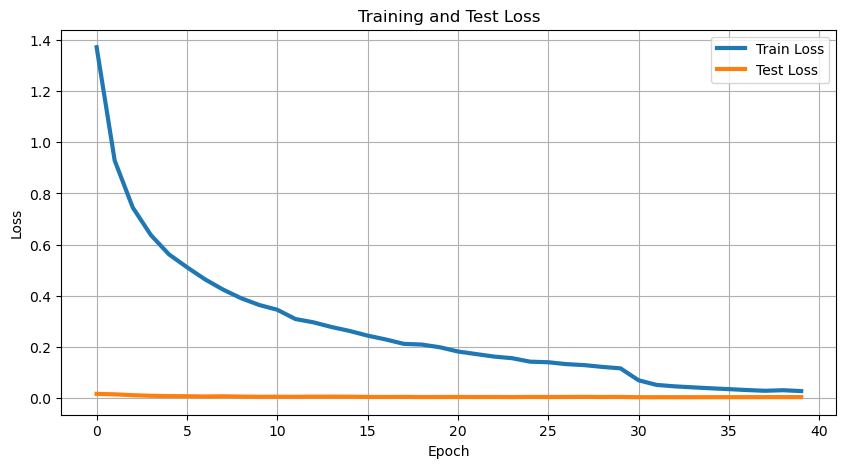

In [79]:


# Resetting histories in case this block is run multiple times
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

best_accuracy = 0.0
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    total_train_loss = 0.0
    num_batches = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_train_loss += loss.item()
        num_batches += 1

        if (i+1) % 100 == 0:
            print(f'Epoch: {epoch}\n[{i * len(inputs) + 1}/{len(train_loader.dataset)} ({100. * (i + 1) / len(train_loader):.0f}%)]  Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
    scheduler.step()  # Update the learning rate
    avg_train_loss = total_train_loss / num_batches
    train_loss_history.append(avg_train_loss)
    
    # Validation/Test phase
    model.eval()
    total_test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    avg_test_loss = total_test_loss / len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    test_loss_history.append(avg_test_loss)
    test_accuracy_history.append(test_accuracy)

    print(f'\nEpoch {epoch}: Avg. Training Loss: {avg_train_loss:.4f}, Avg. Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n')
    
    # Save the model if it has the best accuracy so far
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), model_path)
        print("Saved best model")

print(f'Execution time: {time.time() - start_time:.2f} seconds')

# Load the best model
model.load_state_dict(torch.load(model_path))
model.eval()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, '-', linewidth=3, label='Train Loss')
plt.plot(test_loss_history, '-', linewidth=3, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()



In [11]:
#load best model
#requires init of model. 
# Step 3: Load the saved model weights.
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Move model to the appropriate device (CPU or GPU)


# Evaluation mode
model.eval()

# Variables to track correct predictions and total predictions
correct = 0
total = 0

# No gradient is needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        
        # Get the predicted classes
        _, predicted = torch.max(outputs.data, 1)
        
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')


Accuracy of the network on the 10000 test images: 92.36%
